In [1]:
import nibabel as nib
import os
import numpy as np
import scipy
import pandas as pd
import scipy.stats
from distribution_plots import *

### Initialisation

In [2]:
# Simulation parameters
nrep = 38; # 38 repeats are available
nsimuperrep = 30*30*30
nreal = nrep*nsimuperrep # Total number of realisations

tau2 = 1 # Between-study variance
nsubjects = 20 # Number of subjects per study
sigma2 = ['{num:02d}'.format(num=int(t*nsubjects)) for t in [0.25, 0.5, 1, 2, 4]] # Possible within-study variances (constant across studies)
sigma2 = np.append(sigma2, 'diff') # 'diff' corresponds to varying within-study variance
kstudies = 25 # Number of studies in the meta-analysis (one-sample)
dof = kstudies - 1 # Degrees of freedom

In [3]:
# Load the data
base_dir = '/Volumes/camille/IBMA_simu/'

wth_n20 = dict()
hat_taus = dict() # mean_random_effects_var1.nii.gz concatenated across (independent) runs & voxels
zstats = dict() # zstat1.nii.gz concatenated across (independent) runs & voxels
meta_varcopes = dict() # varcope1.nii.gz concatenated across (independent) runs & voxels
meta_copes = dict() # cope1.nii.gz concatenated across (independent) runs & voxels

for wth in sigma2:
    hat_taus[wth] = []
    zstats[wth] = []
    meta_varcopes[wth] = []
    meta_copes[wth] = []
    for r in range(1, nrep+1):
        wth_n20[wth, r] = os.path.join(
            base_dir, 
            'test1_k025_n20_btw1_wth' + wth + '_nominal', 
            '{num:04d}'.format(num=r), # Repeat
            'megaMFX/')

for [wth, r], folder in wth_n20.items():
    data_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'mean_random_effects_var1.nii.gz')).get_data().flatten()
    hat_taus[wth] = np.append(hat_taus[wth], data_array)
    z_data_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'zstat1.nii.gz')).get_data().flatten()
    zstats[wth] = np.append(zstats[wth], z_data_array)
    varcope_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'varcope1.nii.gz')).get_data().flatten()
    meta_varcopes[wth] = np.append(meta_varcopes[wth], varcope_array)
    cope_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'cope1.nii.gz')).get_data().flatten()
    meta_copes[wth] = np.append(meta_copes[wth], cope_array)

### Problem statement

Issue: P-values obtained under the null hypothesis using GLM MFX on simulated data presenting varying within-study variance are invalid.


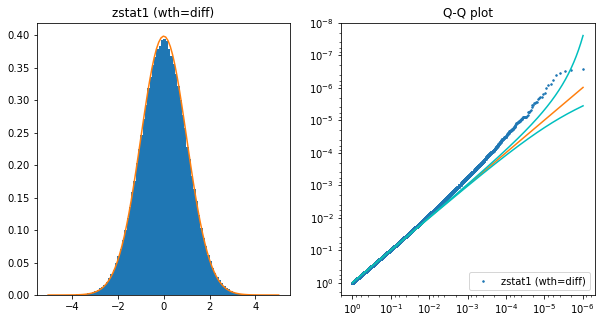

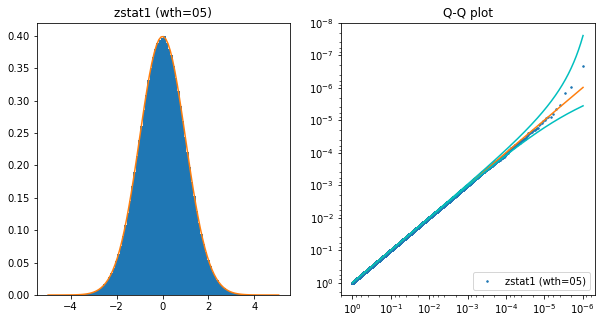

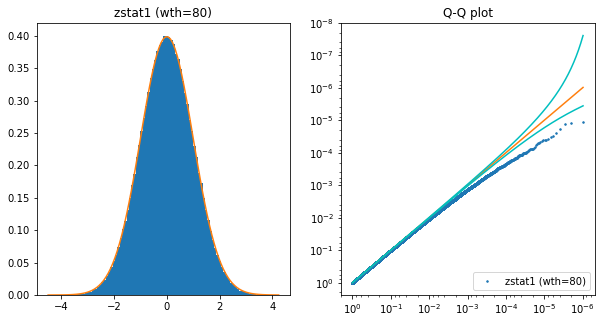

In [4]:
for wth in ['diff', '05', '80']:
    z_distribution_plot(zstats[wth], 'zstat1 (wth=' + wth + ')')

### Look for bias in the random effect variance

In [5]:
for wth, hat_tau in hat_taus.items():
    print('Mean of mean_random_effects_var1 (over ' + str(nreal) + ' realisations) for ' + wth + ' = ' + 
          str(np.mean(hat_tau)) + ' / True tau2=' + str(tau2))

Mean of mean_random_effects_var1 (over 1026000 realisations) for 05 = 1.00886902299 / True tau2=1
Mean of mean_random_effects_var1 (over 1026000 realisations) for 10 = 1.02798506531 / True tau2=1
Mean of mean_random_effects_var1 (over 1026000 realisations) for 20 = 1.08181257246 / True tau2=1
Mean of mean_random_effects_var1 (over 1026000 realisations) for 40 = 1.22330697413 / True tau2=1
Mean of mean_random_effects_var1 (over 1026000 realisations) for 80 = 1.56740477013 / True tau2=1
Mean of mean_random_effects_var1 (over 1026000 realisations) for diff = 1.07518656485 / True tau2=1


The random effect variance is possibly positively biased.

### Look for bias in the meta-analysis varcopes

#### Theoretical distribution of the meta-analysis cope and varcopes under H0

With MFX GLM under the null we have
```
cope ~ N(0, 1/sum(\kappa_i)) with \kappa_i = 1/(\tau^2 + \sigma_i^2)
```
i.e.:

```
cope_05 ~ N(0, 1.25/kstudies)
cope_10 ~ N(0, 1.50/kstudies)
cope_20 ~ N(0, 2/kstudies)
cope_40 ~ N(0, 3/kstudies)
cope_80 ~ N(0, 5/kstudies)

cope_diff ~ N(0, 1/(1/1.25 + 1/1.5 + 1/2 + 1/3 + 1/5))
```



In [6]:
tau2 = 1
kstudies = 25
cope_th_var = dict()

def get_mfx_th_variance(tau2, sigma2_i):
    sigma2_i_ratios = [1/(tau2 + x) for x in sigma2_i]
    th_var_diff = 1/sum(sigma2_i_ratios)
    return(th_var_diff)

# From os.path.join(wth_n20['diff'], os.pardir, 'simu.mat') we see:
wth_sigma_a = [1, 2, 4, 8, 16, 1, 2, 4, 8, 16, 1, 2, 4, 8, 16, 1, 2, 4, 8, 16, 1, 2, 4, 8, 16]
sigma2_i = [x * 0.25 for x in wth_sigma_a]
cope_th_var['diff'] = get_mfx_th_variance(tau2, sigma2_i)
print(cope_th_var['diff'])

# Test calculation with constant within-study variance (sanity check)
sigma2_i = [x*0.25 for x in np.ones(kstudies)]
cope_th_var['05'] = get_mfx_th_variance(tau2, sigma2_i)

if np.isclose(get_mfx_th_variance(tau2, sigma2_i),(tau2+0.25)/kstudies):
    print('Sanity check succeded')
else:
    print('Sanity check failed!')
    print('th_var_cope_05=' + str(get_mfx_th_variance(tau2, sigma2_i)))
    print('th_var_cope_05=' + str((tau2+0.25)/kstudies))
    
cope_th_var['10'] = get_mfx_th_variance(tau2, [x*0.5 for x in np.ones(kstudies)])
cope_th_var['20'] = get_mfx_th_variance(tau2, [x*1 for x in np.ones(kstudies)])
cope_th_var['40'] = get_mfx_th_variance(tau2, [x*2 for x in np.ones(kstudies)])
cope_th_var['80'] = get_mfx_th_variance(tau2, [x*4 for x in np.ones(kstudies)])

0.08
Sanity check succeded


In [7]:
for wth, meta_varcope in meta_varcopes.items():
    print('Mean meta-analytic varcope1 (over ' + str(nreal) + ' realisations) for ' + wth + ' = ' + 
          str(np.mean(meta_varcope)) + ' / True varcope1=' + str(cope_th_var[wth]))

Mean meta-analytic varcope1 (over 1026000 realisations) for 05 = 0.0501427051832 / True varcope1=0.05
Mean meta-analytic varcope1 (over 1026000 realisations) for 10 = 0.0604302613453 / True varcope1=0.06
Mean meta-analytic varcope1 (over 1026000 realisations) for 20 = 0.0812676592655 / True varcope1=0.08
Mean meta-analytic varcope1 (over 1026000 realisations) for 40 = 0.123792171826 / True varcope1=0.12
Mean meta-analytic varcope1 (over 1026000 realisations) for 80 = 0.210882681754 / True varcope1=0.2
Mean meta-analytic varcope1 (over 1026000 realisations) for diff = 0.0809958537712 / True varcope1=0.08


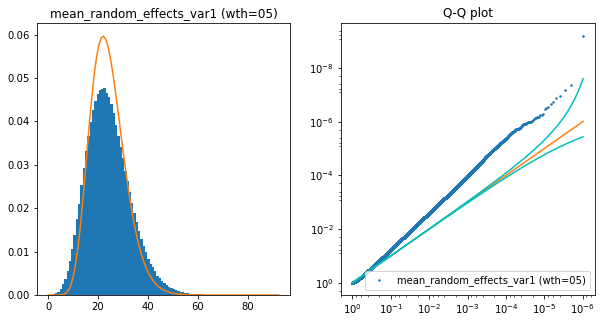

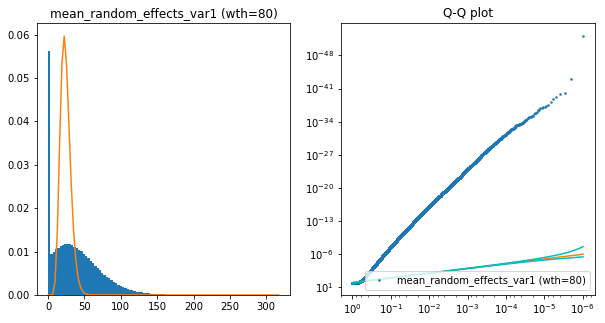

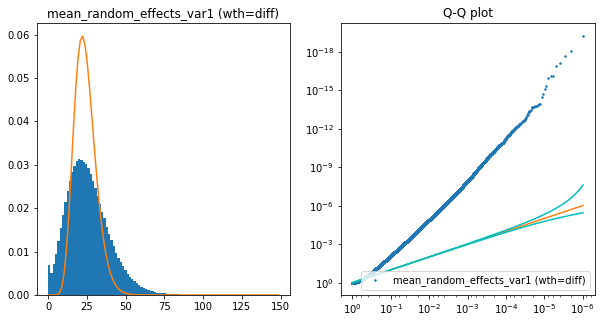

In [8]:
for wth in ['05', '80', 'diff']:
    chi2_distribution_plot(hat_taus[wth]/(tau2/dof), 'mean_random_effects_var1 (wth=' + wth + ')', dof)

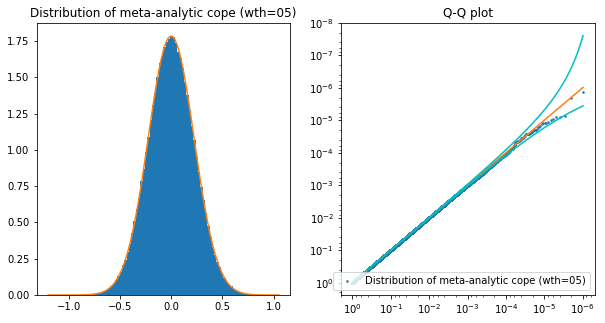

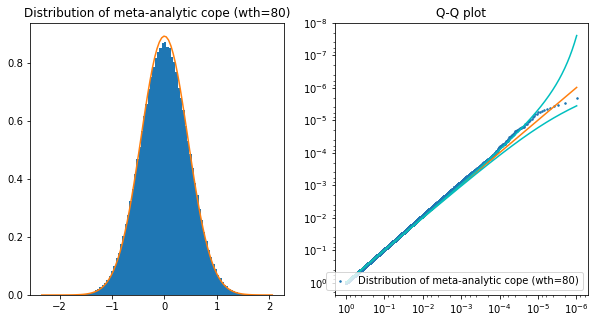

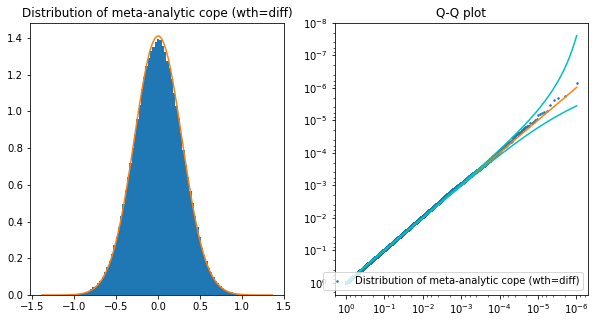

In [9]:
for  wth in ['05', '80', 'diff']:
    z_distribution_plot(
        meta_copes[wth], # cope to display
        'Distribution of meta-analytic cope (wth=' + wth + ')', # Title
        0, np.sqrt(cope_th_var[wth]) # Parameters of the theoretical Normal distribution
    )

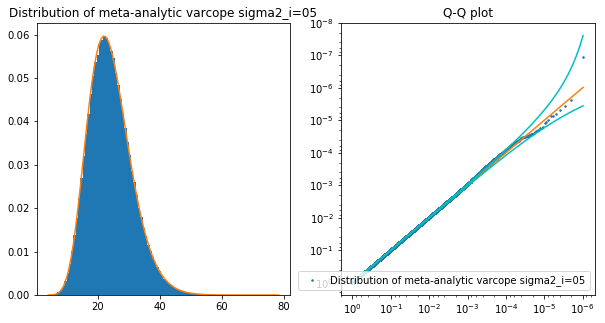

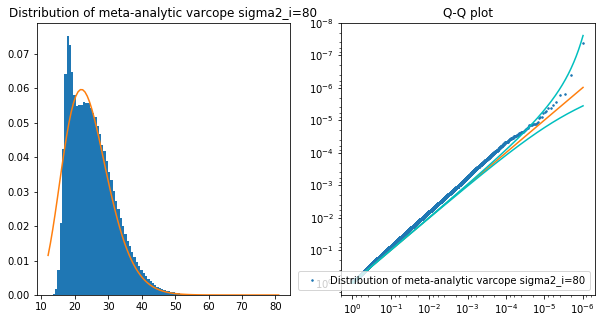

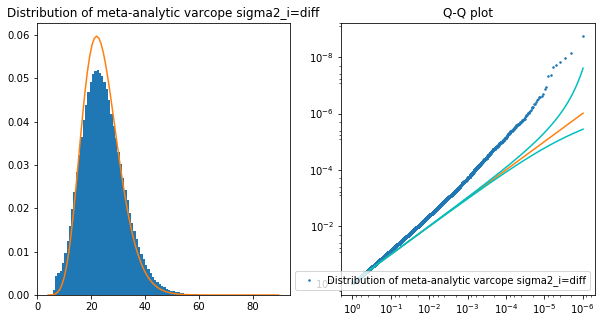

In [10]:
for wth in ['05', '80', 'diff']:
    chi2_distribution_plot(
        meta_varcopes[wth]*dof/(cope_th_var[wth]), # varcope to display scaled by sigma2/dof
        'Distribution of meta-analytic varcope sigma2_i=' + wth, 
        dof # Parameters of the theoretical Chi2 distribution
    )

Meta-analysic varcopes created with MFX GLM:
 - within-study variance = 5 is valid (almost invalid)
 - within-study variance = 80 is invalid in places (but valid at the tail)
 - varying within-study variance invalid thoughout.


In [11]:
# Estimate the degrees of freedom assuming location and scale are known (only on first 27000 samples)
scipy.stats.chi2.fit(meta_varcopes['05'][0:70000]*dof/(cope_th_var['05']), floc=0, fscale=1)

(24.063867187500048, 0, 1)

In [12]:
scipy.stats.chi2.fit(meta_varcopes['diff'][0:70000]*dof/(cope_th_var['diff']), floc=0, fscale=1)

(23.941894531250043, 0, 1)

In [13]:
scipy.stats.chi2.fit(meta_varcopes['80'][0:70000]*dof/(cope_th_var['05']), floc=0, fscale=1)

(98.931445312500145, 0, 1)